# VAE on MNIST

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
from sklearn.manifold import TSNE
import numpy as np
import math
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import time
import pickle
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Define the VAE Architectures

### The Simple VAE that features encoder and decoder with two convolutional layers (32 and 64 filters)

In [ ]:
class SimpleConvVAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(SimpleConvVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # [32, 14, 14]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # [64, 7, 7]
            nn.ReLU(),
            nn.Flatten()
        )


        self.fc_mu = nn.Linear(64*7*7, latent_dim)
        self.fc_logvar = nn.Linear(64*7*7, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 64*7*7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # [32, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # [1, 28, 28]
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z).view(-1, 64, 7, 7)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
def sgvb_loss(recon_x, x, mu, logvar):
    # Reconstruction loss
    # recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum') # because we treat pixels as binary
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # special property for normal dist.

    return recon_loss, kl_loss

In [ ]:
def train(vae, data, beta=1, verbose=True, threshold=0.1, max_epochs=100):
    vae.train()
    recon_history = []; kl_history = []
    opt = torch.optim.Adam(vae.parameters())
    for epoch in range(max_epochs):
        total_recon_loss = 0.0; total_kl_loss = 0.0
        for x, _ in data:    # unsupervised learning, y not used
            x = x # GPU/CPU
            opt.zero_grad()
            x_hat, mu, logvar = vae(x)

            recon_loss, kl_loss = sgvb_loss(x_hat, x, mu, logvar)
            loss = recon_loss + beta * kl_loss
            loss.backward()
            opt.step()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
        avg_recon_loss = total_recon_loss / len(data.dataset)
        avg_kl_loss = total_kl_loss / len(data.dataset)
        # record reconstruction loss and KL loss for the epoch
        recon_history.append(avg_recon_loss)
        kl_history.append(avg_kl_loss)
        if verbose:
            print('Epoch {}...\t Recon loss: {:.6f}, KL loss: {:.6f}, Total loss: {:.6f}'.format(
                epoch+1, avg_recon_loss, avg_kl_loss, avg_recon_loss+beta*avg_kl_loss))
        if epoch > 0 and recon_history[epoch-1]+beta*kl_history[epoch-1]-recon_history[epoch]-beta*kl_history[epoch] < threshold \
                     and recon_history[epoch-2]+beta*kl_history[epoch-2]-recon_history[epoch-1]-beta*kl_history[epoch-1] < threshold:
            break

    return vae, recon_history, kl_history

### Train the models on MNIST

In [ ]:
# latent_dims = [2, 5, 10, 20]
train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', train=True,
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:11<00:00, 892kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:06<00:00, 242kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.2MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
vae = SimpleConvVAE(5)

In [ ]:
# Check the shape and range of data in the data loader
for x, y in train_loader:
    print("Batch shape:", x.shape)
    print("Min, Max pixel values:", x.min(), x.max())
    break

Batch shape: torch.Size([128, 1, 28, 28])
Min, Max pixel values: tensor(0.) tensor(1.)


In [ ]:
vae.train()
for x, _ in train_loader:
    x_hat, mu, logvar = vae(x)
    print("Output shape:", x_hat.shape)
    print("Mu shape:", mu.shape)
    print("Logvar shape:", logvar.shape)
    break


Output shape: torch.Size([128, 1, 28, 28])
Mu shape: torch.Size([128, 5])
Logvar shape: torch.Size([128, 5])


In [ ]:
x, _ = next(iter(train_loader))
x_hat, mu, logvar = vae(x)
recon_loss, kl_loss = sgvb_loss(x_hat, x, mu, logvar)
print("Reconstruction Loss:", recon_loss)
print("KL Loss:", kl_loss)


Reconstruction Loss: tensor(68175.8125, grad_fn=<BinaryCrossEntropyBackward0>)
KL Loss: tensor(0.9208, grad_fn=<MulBackward0>)


In [ ]:
results_simple = {}
trained_vaes_simple = {}
# for dim in latent_dims:
print(f'Training VAE with latent dimension: {5}')
vae = SimpleConvVAE(5)
trained_vae, recon_history, kl_history = train(vae, train_loader)
results_simple[5] = (recon_history, kl_history)
trained_vaes_simple[5] = trained_vae

Training VAE with latent dimension: 5
Epoch 1...	 Recon loss: 165.933815, KL loss: 11.954914, Total loss: 177.888729
Epoch 2...	 Recon loss: 128.033657, KL loss: 11.038578, Total loss: 139.072235
Epoch 3...	 Recon loss: 121.891957, KL loss: 11.116970, Total loss: 133.008928
Epoch 4...	 Recon loss: 118.839670, KL loss: 11.209766, Total loss: 130.049436
Epoch 5...	 Recon loss: 116.901660, KL loss: 11.286082, Total loss: 128.187743
Epoch 6...	 Recon loss: 115.495423, KL loss: 11.377858, Total loss: 126.873281
Epoch 7...	 Recon loss: 114.476643, KL loss: 11.439500, Total loss: 125.916143
Epoch 8...	 Recon loss: 113.662529, KL loss: 11.502696, Total loss: 125.165224
Epoch 9...	 Recon loss: 113.016623, KL loss: 11.545255, Total loss: 124.561878
Epoch 10...	 Recon loss: 112.444976, KL loss: 11.603847, Total loss: 124.048823
Epoch 11...	 Recon loss: 111.991802, KL loss: 11.634785, Total loss: 123.626587
Epoch 12...	 Recon loss: 111.594404, KL loss: 11.677723, Total loss: 123.272126
Epoch 13...

In [ ]:
def freeze_vae(vae):
    """
    Freeze weights of a trained VAE by:
    1. Setting to eval mode
    2. Disabling gradients for all parameters

    Args:
        vae: The trained VAE model to freeze
    Returns:
        The frozen VAE model
    """
    # Set to evaluation mode
    vae.eval()

    # Disable gradient computation
    for param in vae.parameters():
        param.requires_grad = False

    return vae

In [ ]:
frozen_vae = freeze_vae(trained_vaes_simple[5])

In [ ]:
## Standard libraries
import os
import json
import math
import numpy as np
import random

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial8"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

<ipython-input-14-ea11d8cae9d5>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Device: cuda:0


In [ ]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial8/"
# Files to download
pretrained_files = ["MNIST.ckpt", "tensorboards/events.out.tfevents.MNIST"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [ ]:
# Transformations applied on each image => make them a tensor and normalize between -1 and 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_set = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True,  drop_last=True,  num_workers=4, pin_memory=True)
test_loader  = data.DataLoader(test_set,  batch_size=256, shuffle=False, drop_last=False, num_workers=4)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:10<00:00, 945kB/s] 


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 57.0kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.70MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
class Swish(nn.Module):

    def forward(self, x):
        return x * torch.sigmoid(x)


class CNNModel(nn.Module):

    def __init__(self, hidden_features=32, out_dim=1, **kwargs):
        super().__init__()
        # We increase the hidden dimension over layers. Here pre-calculated for simplicity.
        c_hid1 = hidden_features//2
        c_hid2 = hidden_features
        c_hid3 = hidden_features*2

        # Series of convolutions and Swish activation functions
        self.cnn_layers = nn.Sequential(
                nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4), # [16x16] - Larger padding to get 32x32 image
                Swish(),
                nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1), #  [8x8]
                Swish(),
                nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1), # [4x4]
                Swish(),
                nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1), # [2x2]
                Swish(),
                nn.Flatten(),
                nn.Linear(c_hid3*4, c_hid3),
                Swish(),
                nn.Linear(c_hid3, out_dim)
        )

    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import Normal
import numpy as np

class LatentEBM:
    def __init__(self, energy_net, vae, device="cuda",
                 num_steps=60, step_size=0.01, sample_steps=100):
        """
        Args:
            energy_net: The energy network (your CNNModel)
            vae: The pre-trained and frozen VAE
            device: Device to run computations on
            num_steps: Number of Langevin steps during training
            step_size: Step size for Langevin dynamics
            sample_steps: Number of Langevin steps during sampling
        """
        self.energy_net = energy_net.to(device)
        self.vae = freeze_vae(vae).to(device)
        self.device = device
        self.num_steps = num_steps
        self.step_size = step_size
        self.sample_steps = sample_steps

        # Standard normal prior for VAE latent space
        self.prior = Normal(0, 1)

    def langevin_dynamics(self, z_init, num_steps=None):
      if num_steps is None:
          num_steps = self.num_steps

      z = z_init.detach().clone()
      z.requires_grad = True

      for _ in range(num_steps):
          # Reshape z as input to the VAE decoder
          h = self.vae.fc_decode(z).view(-1, 64, 7, 7)
          x_gen = self.vae.decoder(h)

          # Calculate energy and loss
          energy = self.energy_net(x_gen)
          log_prior = self.prior.log_prob(z).sum(dim=1)
          loss = energy - log_prior

          # Compute gradients and update z
          grad = torch.autograd.grad(loss.sum(), z)[0]
          noise = torch.randn_like(z) * np.sqrt(2 * self.step_size)
          z.data += -self.step_size * grad + noise

      return z.detach()



    def train_step(self, real_batch, optimizer):
      self.energy_net.train()

      # Calculate energy of real samples
      energy_real = self.energy_net(real_batch)

      # Sample latent vectors from prior
      z_init = torch.randn(real_batch.size(0), self.vae.latent_dim,
                          device=self.device)

      # Run Langevin dynamics to get samples
      z_fake = self.langevin_dynamics(z_init)

      # Decode z_fake using fc_decode and reshape for decoder
      h = self.vae.fc_decode(z_fake).view(-1, 64, 7, 7)
      x_fake = self.vae.decoder(h)

      # Calculate energy of generated samples
      energy_fake = self.energy_net(x_fake)

      # Loss is difference between real and fake energies
      loss = energy_fake.mean() - energy_real.mean()

      # Optional: Add energy regularization
      reg_amount = 0.1
      energy_reg = (energy_real ** 2).mean() + (energy_fake ** 2).mean()
      loss = loss + reg_amount * energy_reg

      # Optimization step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      return loss.item()


    def sample(self, num_samples):
        """
        Generates samples by running Langevin dynamics from random latent vectors

        Args:
            num_samples: Number of samples to generate
        Returns:
            Generated samples
        """
        self.energy_net.eval()

        # Sample initial latent vectors from prior
        z_init = torch.randn(num_samples, self.vae.latent_dim,
                           device=self.device)

        # Run Langevin dynamics for more steps during sampling
        z = self.langevin_dynamics(z_init, num_steps=self.sample_steps)

        # Decode final latent vectors
        with torch.no_grad():
            samples = self.vae.decoder(z)

        return samples

In [ ]:
# Your existing energy network
energy_net = CNNModel(hidden_features=32)

# Create the latent EBM
latent_ebm = LatentEBM(energy_net, frozen_vae, device=device)

In [ ]:
# Setup optimizer
optimizer = torch.optim.Adam(latent_ebm.energy_net.parameters(), lr=1e-4)

# Training loop
num_epochs = 10  # Paper mentions very few epochs needed
for epoch in range(num_epochs):
    print(epoch)
    running_loss = 0.0

    for batch in train_loader:  # Your data loader
        real_images = batch[0].to(device)  # Assuming batch is (images, labels)
        loss = latent_ebm.train_step(real_images, optimizer)
        running_loss += loss

    # Print progress
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

0
Epoch [1/10], Average Loss: -4.1686
1
Epoch [2/10], Average Loss: -4.9947
2
Epoch [3/10], Average Loss: -4.9989
3
Epoch [4/10], Average Loss: -4.9991
4
Epoch [5/10], Average Loss: -4.9993
5
Epoch [6/10], Average Loss: -4.9994
6
Epoch [7/10], Average Loss: -4.9996
7
Epoch [8/10], Average Loss: -4.9997
8
Epoch [9/10], Average Loss: -4.9997
9
Epoch [10/10], Average Loss: -4.9998


Initial z_init shape: torch.Size([16, 5])
z shape after Langevin dynamics: torch.Size([16, 5])
h shape for decoder input in sample: torch.Size([16, 64, 7, 7])
Final sample shape after decoding: torch.Size([16, 1, 28, 28])
Generated samples shape for visualization: torch.Size([16, 1, 28, 28])


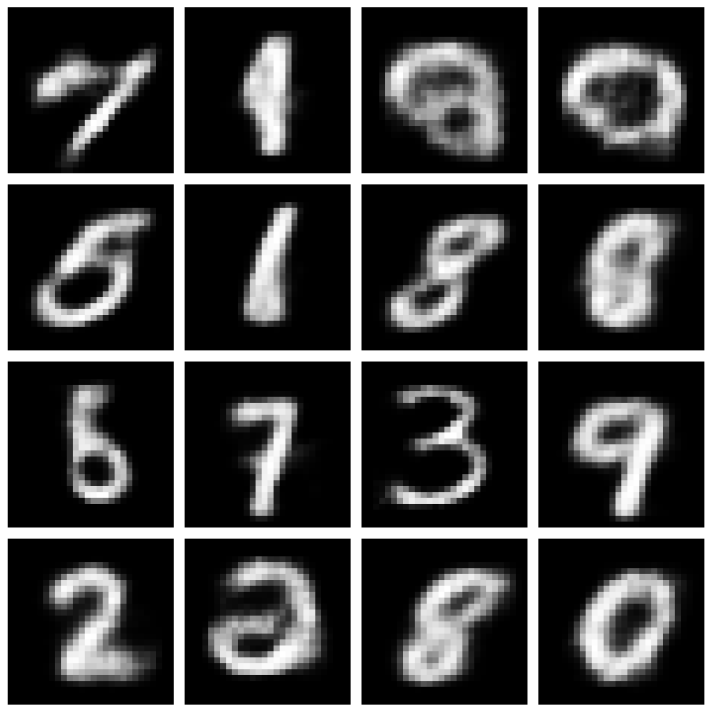

In [ ]:
import torch
import matplotlib.pyplot as plt

# Function to generate and visualize images without retraining
def generate_and_visualize_samples(latent_ebm, num_samples=16):
    # Generate samples
    samples = latent_ebm.sample(num_samples).cpu().detach()
    print(f"Generated samples shape for visualization: {samples.shape}")

    # Plot the samples in a grid
    num_rows = int(num_samples ** 0.5)
    fig, axes = plt.subplots(num_rows, num_rows, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        img = samples[i].squeeze().numpy()  # Reshape the sample if needed
        ax.imshow(img, cmap="gray")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Updated sample function in LatentEBM with print statements
def sample(self, num_samples):
    """
    Generates samples by running Langevin dynamics from random latent vectors
    """
    self.energy_net.eval()

    # Sample initial latent vectors from prior
    z_init = torch.randn(num_samples, self.vae.latent_dim, device=self.device)
    print(f"Initial z_init shape: {z_init.shape}")

    # Run Langevin dynamics for more steps during sampling
    z = self.langevin_dynamics(z_init, num_steps=self.sample_steps)
    print(f"z shape after Langevin dynamics: {z.shape}")

    # Decode final latent vectors with appropriate reshaping
    with torch.no_grad():
        h = self.vae.fc_decode(z).view(-1, 64, 7, 7)
        print(f"h shape for decoder input in sample: {h.shape}")

        samples = self.vae.decoder(h)
        print(f"Final sample shape after decoding: {samples.shape}")

    return samples

# Attach the updated sample method to the existing latent_ebm object
import types
latent_ebm.sample = types.MethodType(sample, latent_ebm)

# Generate and visualize 16 samples
generate_and_visualize_samples(latent_ebm, num_samples=16)


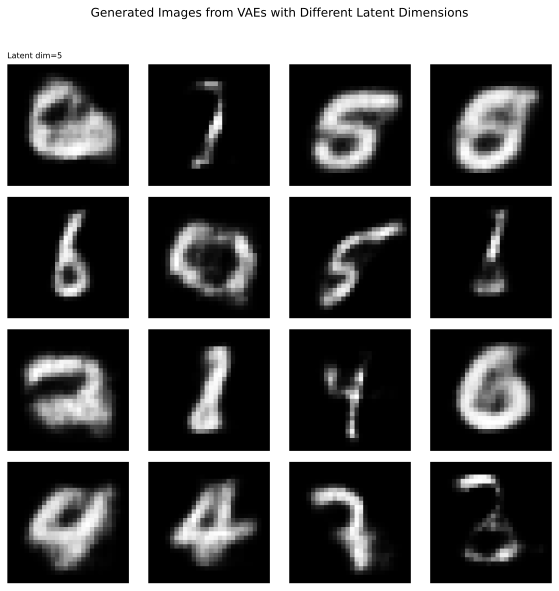

In [ ]:
import matplotlib.pyplot as plt
import torch

def generate_images(autoencoders, num_images=16, dim=5):
    rows, cols = 4, 4  # Define grid size
    fig, axes = plt.subplots(rows, cols, figsize=(8, 8))  # Increase figsize for larger images
    autoencoder = autoencoders[dim]
    autoencoder.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        # Sample from the latent space
        z = torch.randn(num_images, dim).to(device)  # Sample from standard normal distribution
        generated_images = autoencoder.decode(z)  # Decode the latent vectors
        generated_images = generated_images.to('cpu').detach().numpy()  # Move to CPU and convert to numpy array

        for i in range(rows):
            for j in range(cols):
                idx = i * cols + j  # Calculate the flat index
                axes[i, j].imshow(generated_images[idx].reshape(28, 28), cmap='gray')  # Plot in 4x4 grid
                axes[i, j].axis('off')
        axes[0, 0].set_title(f'Latent dim={dim}', loc='left', fontsize=8)

    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing
    plt.suptitle('Generated Images from VAEs with Different Latent Dimensions', y=1.02)
    plt.tight_layout()
    plt.show()

# Example usage
generate_images(trained_vaes_simple, num_images=16, dim=5)



In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 50.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


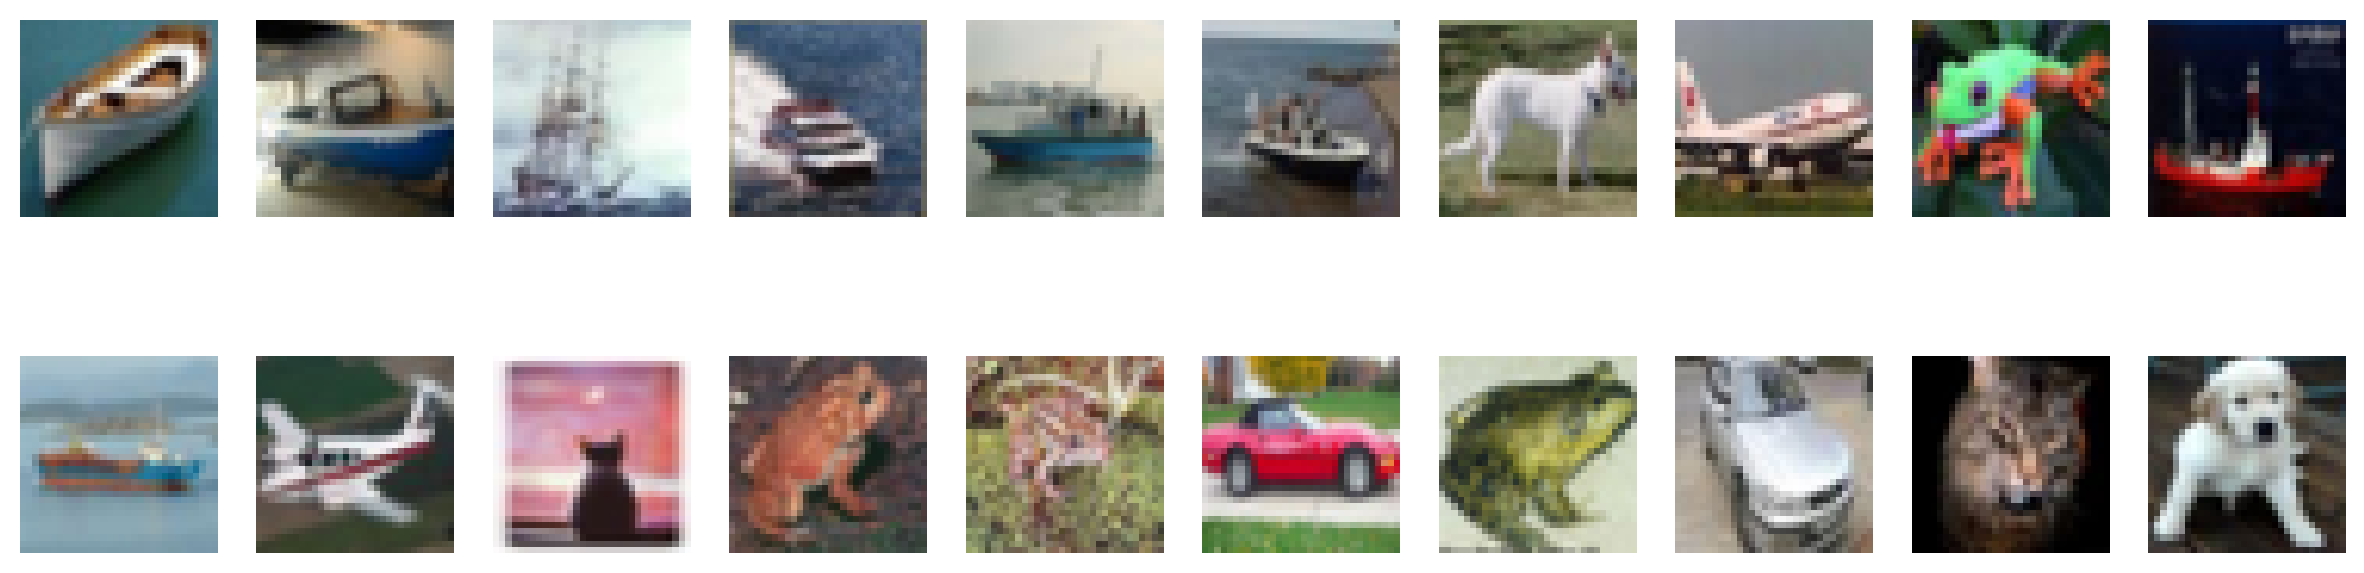

In [ ]:
def show_images(loader, num_images=20):
    # Get a batch of images from the loader
    dataiter = iter(loader)
    images, labels = next(dataiter)

    # Unnormalize the images
    images = images / 2 + 0.5  # Unnormalize to [0,1] range

    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 4))
    for idx in range(num_images):
        img = images[idx]
        img = np.transpose(img.numpy(), (1, 2, 0))
        row = idx // (num_images // 2)
        col = idx % (num_images // 2)
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
    plt.show()

# Usage example:
show_images(trainloader)

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # (batch_size, 64, 16, 16)
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # (batch_size, 128, 8, 8)
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),  # (batch_size, 256, 4, 4)
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256*4*4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # (batch_size, 128, 8, 8)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # (batch_size, 64, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),  # (batch_size, 3, 32, 32)
            nn.Tanh()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 256, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar

In [ ]:
def sgvb_loss(x_hat, x, mu, logvar):
    recon_loss = F.mse_loss(x_hat, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss, kl_loss

In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm  # For a progress bar

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the VAE model and move it to the device
latent_dim = 64
model2 = VAE(latent_dim=latent_dim).to(device)

# Set up optimizer
optimizer = optim.Adam(model2.parameters(), lr=1e-3)

In [ ]:
# Define the training loop
def train_vae(model, trainloader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_recon_loss, total_kl_loss = 0, 0

        for batch in tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, _ = batch
            images = images.to(device)  # Move images to the device

            # Forward pass
            optimizer.zero_grad()
            x_reconstructed, mu, logvar = model(images)
            recon_loss, kl_loss = sgvb_loss(x_reconstructed, images, mu, logvar)
            loss = recon_loss + kl_loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()

        print(f"Epoch {epoch+1}, Recon Loss: {total_recon_loss:.2f}, KL Loss: {total_kl_loss:.2f}")

# Train the model
train_vae(model2, trainloader, num_epochs=10)


Epoch 1/10: 100%|██████████| 391/391 [05:11<00:00,  1.26it/s]


Epoch 1, Recon Loss: 13342999.78, KL Loss: 2070868.84


Epoch 2/10: 100%|██████████| 391/391 [05:11<00:00,  1.26it/s]


Epoch 2, Recon Loss: 7895312.63, KL Loss: 2631486.09


Epoch 3/10: 100%|██████████| 391/391 [05:11<00:00,  1.25it/s]


Epoch 3, Recon Loss: 7148805.26, KL Loss: 2810486.36


Epoch 4/10: 100%|██████████| 391/391 [05:12<00:00,  1.25it/s]


Epoch 4, Recon Loss: 6825420.07, KL Loss: 2904295.16


Epoch 5/10: 100%|██████████| 391/391 [05:15<00:00,  1.24it/s]


Epoch 5, Recon Loss: 6619075.67, KL Loss: 2967118.96


Epoch 6/10: 100%|██████████| 391/391 [05:16<00:00,  1.24it/s]


Epoch 6, Recon Loss: 6494244.72, KL Loss: 2998081.47


Epoch 7/10: 100%|██████████| 391/391 [05:13<00:00,  1.25it/s]


Epoch 7, Recon Loss: 6417668.29, KL Loss: 3015358.70


Epoch 8/10: 100%|██████████| 391/391 [05:13<00:00,  1.25it/s]


Epoch 8, Recon Loss: 6348790.37, KL Loss: 3034309.26


Epoch 9/10: 100%|██████████| 391/391 [05:13<00:00,  1.25it/s]


Epoch 9, Recon Loss: 6315707.14, KL Loss: 3037551.25


Epoch 10/10: 100%|██████████| 391/391 [05:09<00:00,  1.26it/s]

Epoch 10, Recon Loss: 6281835.79, KL Loss: 3039678.47


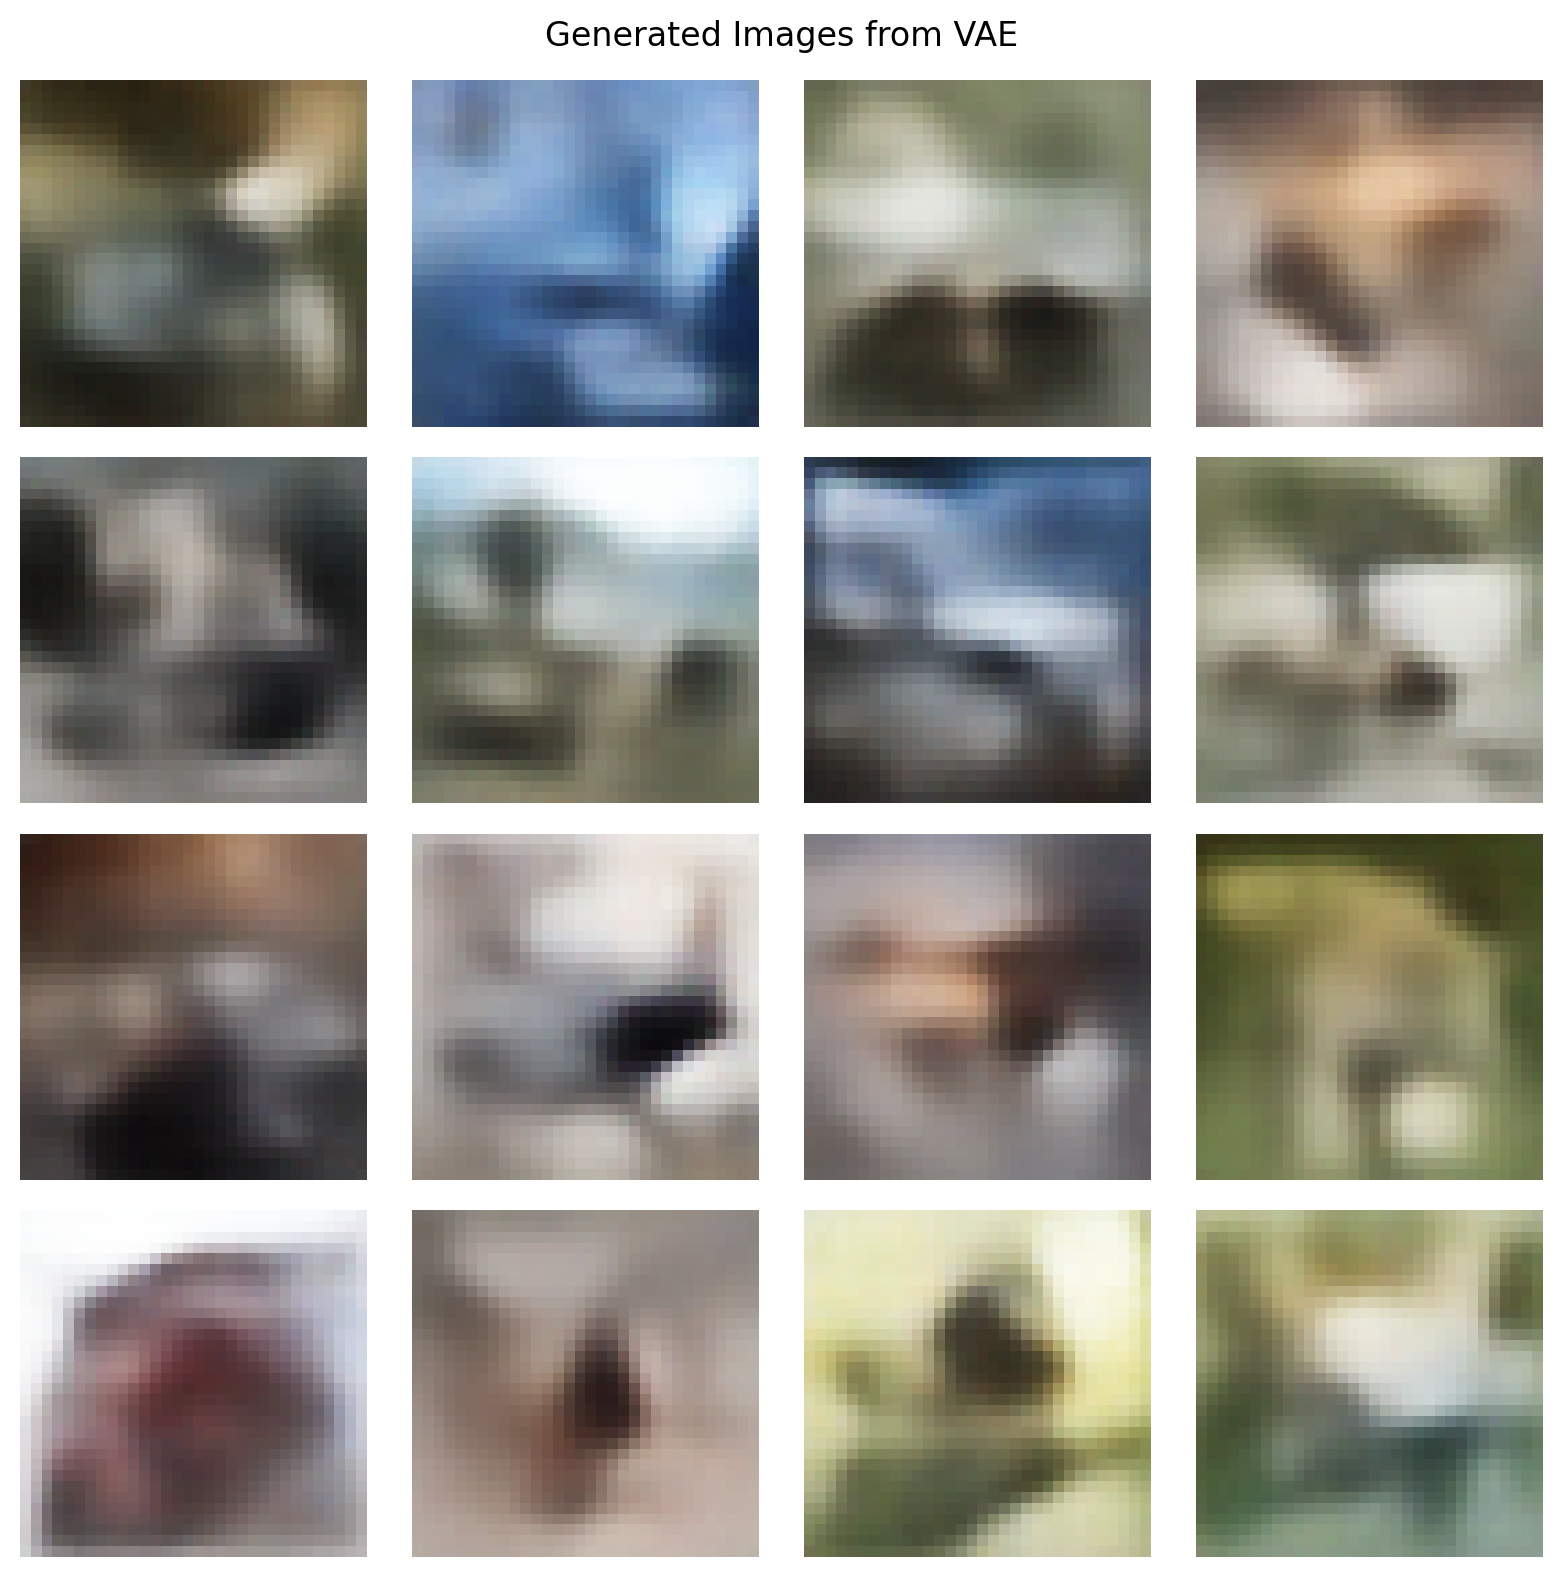

In [ ]:
import matplotlib.pyplot as plt

def generate_and_display_images(model, num_images=16):
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        # Sample from the latent space
        z = torch.randn(num_images, latent_dim).to(device)
        generated_images = model.decode(z)  # Decode to images
        generated_images = generated_images.to('cpu').detach().numpy()  # Move to CPU and convert to numpy array

        # Plot images in a 4x4 grid
        fig, axes = plt.subplots(4, 4, figsize=(8, 8))
        for i, ax in enumerate(axes.flat):
            img = (generated_images[i].transpose(1, 2, 0) + 1) / 2  # Rescale pixel values to [0, 1]
            ax.imshow(img)
            ax.axis('off')

        plt.suptitle('Generated Images from VAE')
        plt.tight_layout()
        plt.show()

# Generate and display images
generate_and_display_images(model2, num_images=16)

In [ ]:
def freeze_vae(vae):
    """
    Freeze weights of a trained VAE by:
    1. Setting to eval mode
    2. Disabling gradients for all parameters

    Args:
        vae: The trained VAE model to freeze
    Returns:
        The frozen VAE model
    """
    # Set to evaluation mode
    vae.eval()

    # Disable gradient computation
    for param in vae.parameters():
        param.requires_grad = False

    return vae

In [ ]:
# Freeze the trained VAE model
frozen_vae = freeze_vae(model2)

In [ ]:
class Swish(nn.Module):

    def forward(self, x):
        return x * torch.sigmoid(x)

In [ ]:
class CNNModel2(nn.Module):
    def __init__(self, hidden_features=32, out_dim=1, **kwargs):
        super().__init__()
        c_hid1 = hidden_features // 2  # 16
        c_hid2 = hidden_features       # 32
        c_hid3 = hidden_features * 2   # 64

        # Separate the convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, c_hid1, kernel_size=5, stride=2, padding=4),  # (batch_size, 16, 18, 18)
            Swish(),
            nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1),  # (batch_size, 32, 9, 9)
            Swish(),
            nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1),  # (batch_size, 64, 5, 5)
            Swish()
        )

        # Separate the fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(c_hid3 * 5 * 5, c_hid3),  # Input: (batch_size, 1600) -> (batch_size, 64)
            Swish(),
            nn.Linear(c_hid3, out_dim)  # (batch_size, 64) -> (batch_size, out_dim)
        )

    def forward(self, x):
        # For debugging
        # print(f"Input shape: {x.shape}")

        # Pass through convolutional layers
        x = self.conv_layers(x)
        # print(f"After conv layers shape: {x.shape}")

        # Pass through fully connected layers
        x = self.fc_layers(x)
        # print(f"Final output shape: {x.shape}")

        return x

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import Normal
import numpy as np

In [ ]:
class LatentEBM2:
    def __init__(self, energy_net, vae, device="cuda", num_steps=60, step_size=0.01, sample_steps=100):
        self.energy_net = energy_net.to(device)
        self.vae = freeze_vae(vae).to(device)
        self.device = device
        self.num_steps = num_steps
        self.step_size = step_size
        self.sample_steps = sample_steps
        self.prior = Normal(0, 1)

    def langevin_dynamics(self, z_init, num_steps=None):
        if num_steps is None:
            num_steps = self.num_steps

        z = z_init.detach().clone()
        z.requires_grad = True

        for step in range(num_steps):
            # Print shape of z
            # print(f"Step {step}, z shape: {z.shape}")

            h = self.vae.decoder_input(z).view(-1, 256, 4, 4)  # Reshape to match decoder input
            # print(f"Step {step}, h shape after decoder_input: {h.shape}")

            x_gen = self.vae.decoder(h)
            # print(f"Step {step}, x_gen shape: {x_gen.shape}")

            energy = self.energy_net(x_gen)
            log_prior = self.prior.log_prob(z).sum(dim=1)
            loss = energy - log_prior

            grad = torch.autograd.grad(loss.sum(), z)[0]
            noise = torch.randn_like(z) * np.sqrt(2 * self.step_size)
            z.data += -self.step_size * grad + noise

        return z.detach()

    def train_step(self, real_batch, optimizer):
        # print("Entering train_step...")
        # print(f"real_batch shape: {real_batch.shape}")
        self.energy_net.train()
        energy_real = self.energy_net(real_batch)
        # print(f"energy_real shape: {energy_real.shape}")
        energy_real = self.energy_net(real_batch)

        z_init = torch.randn(real_batch.size(0), self.vae.fc_mu.out_features, device=self.device)
        # print(f"Initial z_init shape: {z_init.shape}")

        z_fake = self.langevin_dynamics(z_init)

        h = self.vae.decoder_input(z_fake).view(-1, 256, 4, 4)
        # print(f"h shape after decoder_input on z_fake: {h.shape}")

        x_fake = self.vae.decoder(h)
        # print(f"x_fake shape: {x_fake.shape}")

        energy_fake = self.energy_net(x_fake)
        loss = energy_fake.mean() - energy_real.mean()

        reg_amount = 0.1
        energy_reg = (energy_real ** 2).mean() + (energy_fake ** 2).mean()
        loss = loss + reg_amount * energy_reg

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()

    def sample(self, num_samples):
        self.energy_net.eval()

        z_init = torch.randn(num_samples, self.vae.fc_mu.out_features, device=self.device)
        # print(f"Sampling z_init shape: {z_init.shape}")

        z = self.langevin_dynamics(z_init, num_steps=self.sample_steps)

        with torch.no_grad():
            h = self.vae.decoder_input(z).view(-1, 256, 4, 4)
            # print(f"h shape after decoder_input in sample: {h.shape}")
            samples = self.vae.decoder(h)

        return samples


In [ ]:
# Create an instance of your energy network
energy_net = CNNModel2().to(device)

# Create a dummy batch of real images to test
dummy_batch = torch.randn(128, 3, 32, 32).to(device)  # Simulate CIFAR-10 images

# Forward pass through the energy network
try:
    output = energy_net(dummy_batch)
    print(f"Energy net output shape: {output.shape}")  # Should print the output shape
except Exception as e:
    print(f"Error during forward pass in energy_net: {e}")


Energy net output shape: torch.Size([128, 1])


In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm

# Instantiate the energy network and freeze the pretrained CIFAR-10 VAE
energy_net = CNNModel2(hidden_features=64)
frozen_vae = freeze_vae(model2)  # Use your pretrained VAE model

# Create the latent EBM instance
latent_ebm = LatentEBM2(energy_net, frozen_vae, device=device)

# Set up the optimizer for the EBM
optimizer = optim.Adam(latent_ebm.energy_net.parameters(), lr=1e-4)

# Training loop for the latent EBM
num_epochs = 1
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    running_loss = 0.0

    for batch in tqdm(trainloader):  # Use your CIFAR-10 trainloader
        real_images = batch[0].to(device)  # CIFAR-10 images
        loss = latent_ebm.train_step(real_images, optimizer)
        running_loss += loss

    avg_loss = running_loss / len(trainloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")


Epoch 1/1


100%|██████████| 391/391 [2:23:30<00:00, 22.02s/it]

Epoch [1/1], Average Loss: -2.0047


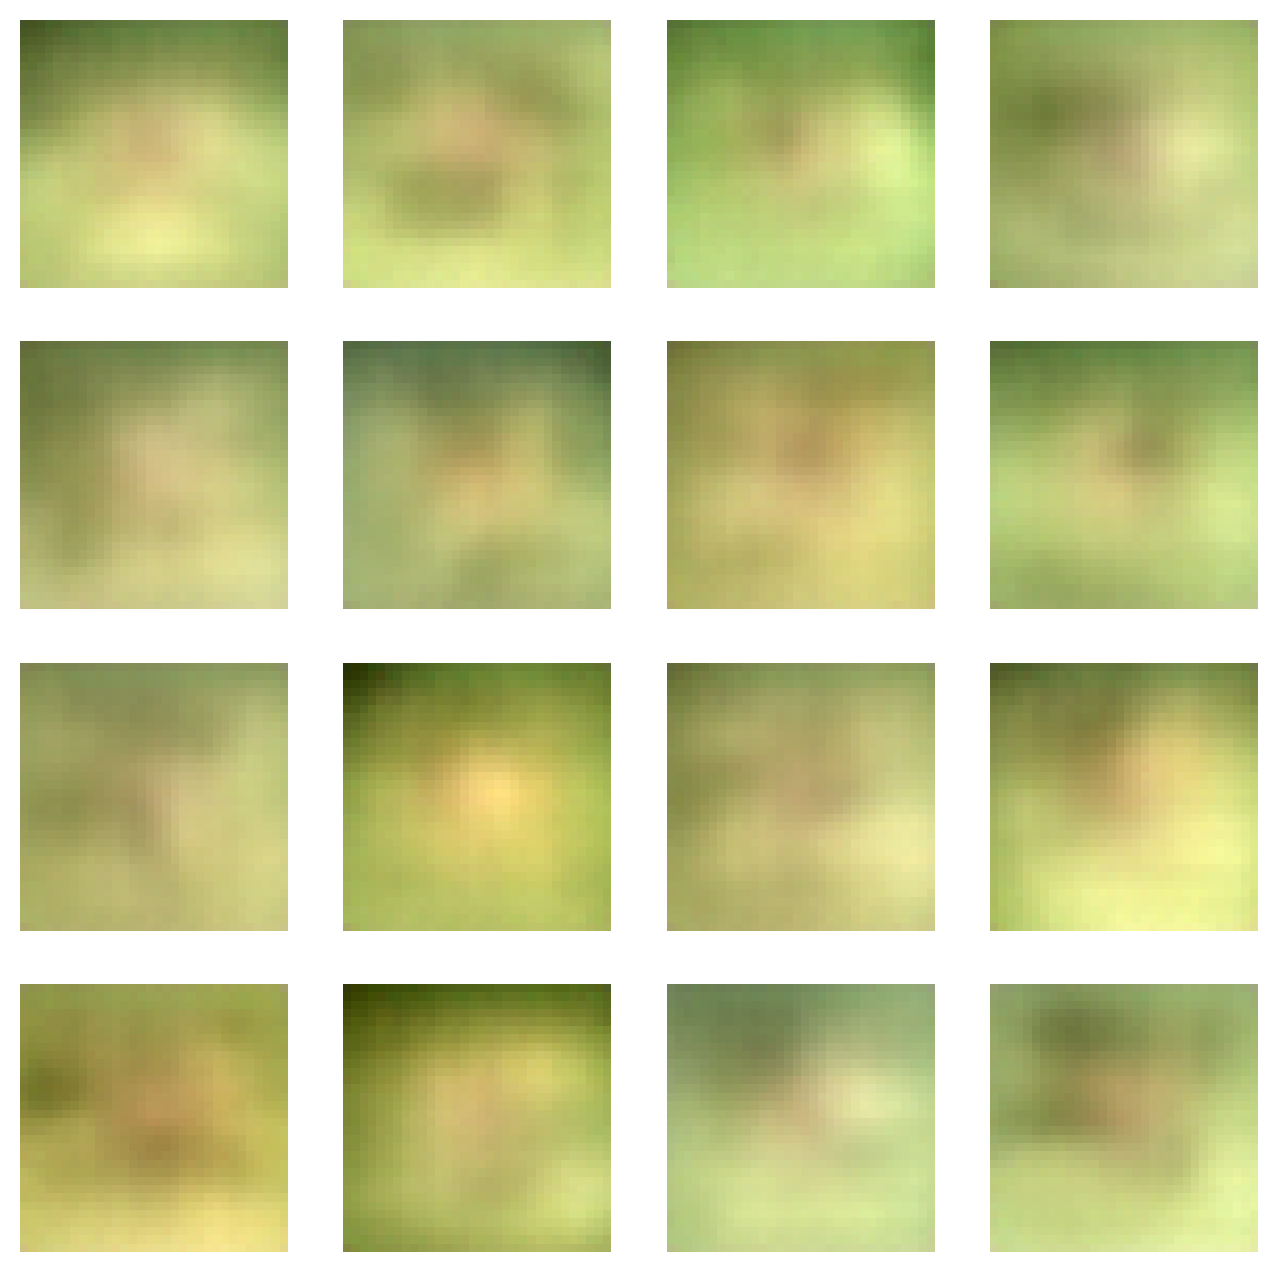

In [ ]:
import matplotlib.pyplot as plt

# Set the number of samples you want to generate
num_samples = 16

# Generate the samples using the latent EBM
generated_samples = latent_ebm.sample(num_samples)

# Move generated samples to CPU and detach from the computation graph for visualization
generated_samples = generated_samples.cpu().detach()

# Plot the generated samples
def plot_images(images, n_rows=4, n_cols=4):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 8))
    for i in range(n_rows * n_cols):
        img = images[i].permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C) for visualization
        axes[i // n_cols, i % n_cols].imshow(img)
        axes[i // n_cols, i % n_cols].axis('off')
    plt.show()
# Normalize pixel values to be in the range [0, 1]
generated_samples = (generated_samples - generated_samples.min()) / (generated_samples.max() - generated_samples.min())

# Plot the generated samples
plot_images(generated_samples)
